# CAB420 Classification, Bonus Example: HOG
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

### Glossary

In writing my commentary for this example, I realised I was throwing a lot of terms around that may be new. So, with that in mind, here's some definitions:
* Feature Transform: A way of changing how our data is represented. Adding higher order terms in linear regression is a simple example of a transform. The HOG method we consider here will transform the images into an alternate representation.
* Image Data: Data in the form of images. Each image is a "sample" here. With images, we have some implicit ordering of data (i.e. adjacent pixels are probably related, they might belong to the same object or something). The classifiers we're looking at here don't exploit this however.
* Pixel: A single element of an image. If we consider our image to be a matrix, then one cell of that matrix is a pixel.
* Tabular Data: Data that's in a table. Each row of the table is a sample. Typically, one column will be the response, the others will be our input variables (or features). 
* Vectorisation: The process of converting an image (or n-dimensional thing where n is greater than 1) to a 1D representation.

## Overview

To allay any concerns, yes, this example is vegan. We are not talking about the source of pork, but rather the *Histogram of Orientated Gradients*, no pulled pork reciepies here (though in brief, I recommend letting the pork soak for a day or two in apple cider vinegar; and then using applying a rub based around salt, smoked paprika, cumin, chipotle, onion power, garlic power and corriander seed; and then smoke low and slow). 

So, why do I want histograms of gradients? Let's think about our classification methods so far. With tabular data, we might have a dataset with 10 columns, the first 9 are different properties of the thing that we're interested in, and the last column is our class. We take the first 9, use them to decide on the class. One critical thing here is that the first 9 columns are always the same, and always in the same order. If we suddenly change the order of those columns, any model we've trained is invalid and won't perform as we expect.

Now consider an image. An image is a collection of pixels. While we can essentially look at an image as a matrix (2D if it's grayscale, 3D if it's colour), the classification methods we've looked at so far are all about processing 1D data, so to classify an image we'd vectorise it. This is shown below:

```
   1 4 1
   4 4 4    ->   1 4 1 4 4 4 1 4 1
   1 4 1
```
We go from a 2D matrix to a vector by taking each column and just stacking them, one on top of the other.

Much like our tabular data, now each dimension has a meaning. In our case, the first dimension is the top left corner of the image, and the last dimension is the bottom right corner. Other dimensions also have a fixed "meaning", i.e. they correspond to a location in the image.

At first glance this might seem fine, but there are a couple of issues:
* We get big feature vectors quickly. Our $3 \times 3$ image only gives us $9$ dimensions (also known as features), but what about a $200 \times 200 \times 3$ image (i.e. 200 pixels wide, 200 pixels high, and in colour)? This gives us $120,000$ dimensions. A lot of classification methods will start to grind a bit with representations of that size.
* What happens if we take an image, and shift it one pixel to the left? Or one pixel up, or down, or right? None of these operations change the underlying meaning of the image. If it was an image of a narwhal, it is still an image of a narwhal. But the *order* of the data has now been changed.
* What happens if the lighting changes? This will change the contrast, the brightness, etc. Every pixel value will change, some by a lot - but the underlying thing in the image is the same.

What we want is a way to make our data representation more compact, while also making it less sensitive to small changes in the image, such as the image being translated (i.e. shifted) slightly, and ideally invariant to other factors such as lighting. There are a lot of ways to do this, and the method we'll consider here, the Histogram of Orientated Gradients (HOG), is one such as approach.

HOG will take an image and divide it into a grid. Within each grid cell, it will look at the gradients of the pixels. The gradient of each pixel is characterised by a magnitude, and a direction. The magnitude tells us how strong the gradient is, the direction simply tells us in which direction the gradient is moving. Strong gradients correspond to edges, and with the direction we can determine if the edge is a vertical, horizontal, or something else. All up, this gradient information tells us about the local texture in the patch. When we aggregate patches across the image, we get an idea of the gradient/texture across the image, and we can use this as the feature to represent the image. Compared to raw pixels, we get:
* A more compact feature representation (unless we have tiny images)
* Something that is invariant to small translations and shifts
* Something that has at least some invariance to other external factors (lighting, etc).

Enough preamble, let's crack(ling) on and have a look at HOG.

### Where does this fit into all the other CAB420 content?

This is, kind of, the bridge between old-school pre-deep learning classification, and deep learning. The HOG transform can be seen as a fixed convolutional filter, while an SVM has more than a passing resembelence to a dense layer. The methods presented here were very widely used (and very successful) until the DCNNs turned up on the scene, and this example may also be of use in Assignment 2 depending on what you choose to do.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.svm import SVC
from skimage.feature import hog, local_binary_pattern
from skimage import data, exposure
from sklearn.metrics import ConfusionMatrixDisplay

## Data Loading

I've gone a bit rogue here. I didn't want to use Fashion MNIST again, so I've pulled a dataset from TensorFlow's collection. I don't really want to go into what I'm doing here, as it takes away from the core message of this example (and I'm all about staying on task).

But don't fear, there's another more detailed bonus example over in the DCNN space where I talk these up. In brief though, what I'm going to do is:
* Load the data from tensorflow_datasets
* Convert the data to a simple numpy array to make the rest of this a bit more familar and easy to work with
* Display some images as a sanity check
* Vectorise my images (for now)

**NOTE**: This approach is fine here, as the dataset is small. This sort of conversion is **not** recommended for a large dataset. Go and look at the more detailed TFDS example for more info.

**ANOTHER NOTE**: To emphasise how not ideal this approach is, I've has to add the resize mapping to get this to work with the QUT-hosted JupyterLab environment, otherwise it runs out of memory and the kernal curls up in a corner and dies. **If you are on JupyterLab and running this, make sure the two map calls that use resize are uncommented."

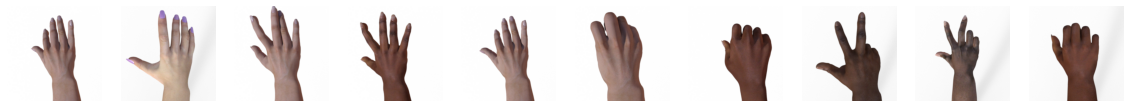

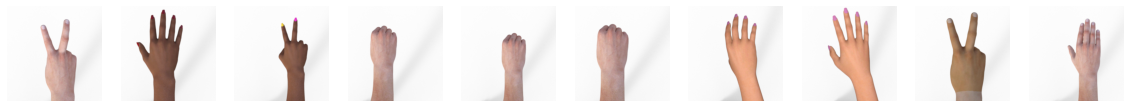

In [2]:
# simple resize function to shrink our images
def resize(image, label):
    image = tf.image.resize(image,[100,100])
    return (image,label)

# convert the contents of a tfds to a couple of numpy arrays
def convert_to_numpy(ds):
    
    x = []
    y = []

    # loop through the dataste
    for im,l in ds:
        # add the images and their labels to x and y lists
        x.append(im)
        y.append(l)

    # convert lists to arrays
    x = np.array(x)
    y = np.array(y)
    # convert the images to a float, and scale by 1/255
    x = (x.astype(np.float32) / 255.0)
    
    # return the newly converted x and y
    return x, y

# load a tdfs dataset, and convert it to numpy
def load_tfds(dataset):
    # load the data
    (ds_train, ds_test), ds_info = tfds.load(
        dataset,
        split=['train', 'test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
    )
    
    #
    # NOTE: This is only needed for the JupyterLab environment to avoid running out of 
    # memory and having the kernal die. If you are on jupyter lab, add these two lines
    # in
    #
    #ds_train = ds_train.map(resize)
    #ds_test = ds_test.map(resize)

    # convert to numpy
    x_train, y_train = convert_to_numpy(ds_train)
    x_test, y_test = convert_to_numpy(ds_test)

    # return the numpy version of the data
    return (x_train, y_train), (x_test, y_test)

# pictures, lots of pictures
def display_images(data, num_images):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, :], cmap='gray')
        ax[i].axis('off')
    plt.show()

# vectorise images, convert each image to a vector
def vectorise_images(images):
    return np.reshape(images, (images.shape[0], -1))

# load the data
(x_train, y_train), (x_test, y_test) = load_tfds('rock_paper_scissors')

# display the first 10 images of the train and test sets
display_images(x_train, 10)
display_images(x_test, 10)

Above, you can see our dataset. Rock, paper, ~~shotgun~~ scissors.

## A First Approach

Let's start by applying the simple approach. We'll vectorise our data, and just whack that through an SVM. 

In [3]:
x_train_vec = vectorise_images(x_train)
x_test_vec = vectorise_images(x_test)

print(x_train.shape)
print(x_train_vec.shape)
print(y_train.shape)
print(x_test.shape)
print(x_test_vec.shape)
print(y_test.shape)

(2520, 300, 300, 3)
(2520, 270000)
(2520,)
(372, 300, 300, 3)
(372, 270000)
(372,)


Looking at our data shapes, we can see that:
* We don't have a ton of data, 2520 training images and 372 testing images
* Our images are big, $300 \times 300 \times 3$. This makes our vectorised features very big. Remember a while back when we said that it was good to have more samples than dimensions? Yeah, that's not going to happen here.

Someone out there reading this (is anyone reading this??) is thinking at this point *"just resize the bloody images you muppet!"*, and I could do that. But I won't. I could also convert them to grayscale, but again, I won't. In part, I won't do this because it defeats the point of what I want to show. But also:
* In this example, I need to go down to $50 \times 50$ grayscale images to get below the number of samples, that's a lot of data to throw away.
* While these images will probably still work at $50 \times 50$ and grayscale, sometimes this is not an option, resizing does throw away info, and it does so in a fairly simple way. There are better ways to reduce feature size.

So, now that we've addressed my stubborness, let's continue.

The SVM with raw pixels took 4274 seconds to train and 31935 seconds to eval. That was really slow.


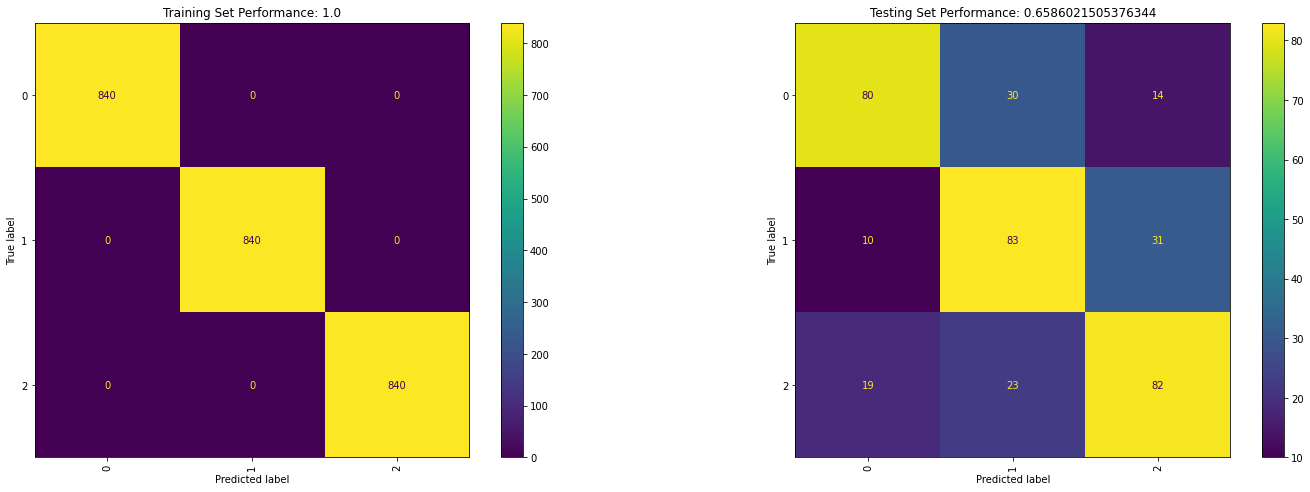

In [4]:
# A suspiciously familiar looking eval function. This will:
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - compute the overall classification accuracy on the testing data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize=None, \
                                                 xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None, \
                                                 xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));

# RBF SVM. A good default option. Though with a feature dimension this high a Linear 
# SVM would also make a lot (if not more) sense.
svm_start = time.process_time()
simple_svm = SVC(kernel='rbf').fit(x_train_vec, y_train)
svm_train_end = time.process_time()
eval_model(simple_svm, x_train_vec, y_train, x_test_vec, y_test)
svm_eval_end = time.process_time()
print('The SVM with raw pixels took %d seconds to train and %d seconds to eval. That was really slow.' % \
      (svm_train_end - svm_start, svm_eval_end - svm_train_end))

My SVM is less than amazing. Lots of overfitting, and it took a long time to do so. The eval times are also quite horrid (SVMs can get slow with large feature representations). In all, we wait a long time for some pretty middling performance.

Again, there will be those of you out there thinkng *"just tune the SVM, do a grid search man!"*, and again, I could. This would no doubt give me a performance boost, and I may well do quite well in the end. But:
* This would take an age.
* This doesn't resolve any of the underlying issues with using raw pixels (lack of invariance to small changes, etc).

## Histogram of Orientated Gradients

Let's get some HOG features. Naturally, there's a function for this in skimage. The main things we need to give it are:
* An image to transform
* The number of orientations we want. This is how many bins our histogram will have. A larger number will mean more fine grained detail about the direction of the gradients (i.e. edges). Bigger values will obviously result in more detail, but will also mean that our resultant transform is more sensitive to small rotations for example.
* The size of each cell. For each cell, we will compute a orientation histogram. Smaller cells mean more spatial detail, but this may increase sensitivity to small translations.
* The number of cells in each block. With HOG, we'll combine cells into a block and "stack" the histograms.

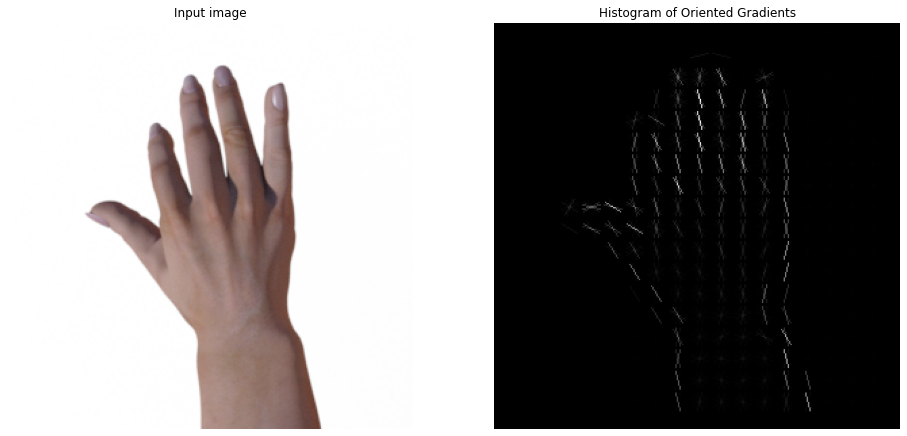

In [5]:
# call HOG. Note that visualise is True. This means that we'll get our transformed feautre back, fd,
# and a visualised image
fd, hog_image = hog(x_train[4,:,:,:], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), visualize=True, channel_axis=2)

# display image and HOG representation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(x_train[4,:,:,:], cmap=plt.cm.gray)
ax1.set_title('Input image')
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

The visualisation above gives a sense of what HOG is doing. We can see a collection of little plolar plots. Each little plot is showing the orientation histogram for a HOG cell. These give us a very clear sense of which image locations contain edges, and the orientation of those edges.

Obviously, we can play a lot with our feature extraction and get some very different looking representations.

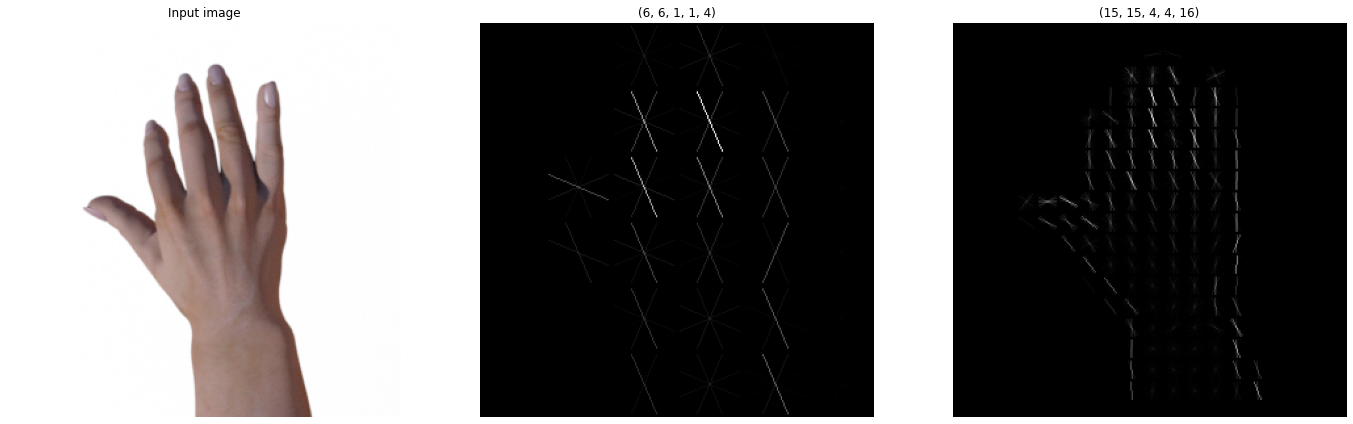

In [6]:
# coarse representation. Very large cells, few orientations.
fd_coarse, hog_image_coarse = hog(x_train[4,:,:,:], orientations=4, pixels_per_cell=(50, 50),
                    cells_per_block=(1, 1), visualize=True, channel_axis=2, feature_vector=False)
# fine representation. Smaller cells, more orientations.
fd_fine, hog_image_fine = hog(x_train[4,:,:,:], orientations=16, pixels_per_cell=(16, 16),
                    cells_per_block=(4, 4), visualize=True, channel_axis=2, feature_vector=False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(x_train[4,:,:,:], cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(exposure.rescale_intensity(hog_image_coarse, in_range=(0, 10)), cmap=plt.cm.gray)
ax2.set_title(fd_coarse.shape)

ax3.axis('off')
ax3.imshow(exposure.rescale_intensity(hog_image_fine, in_range=(0, 10)), cmap=plt.cm.gray)
ax3.set_title(fd_fine.shape)
plt.show()

The two images above show a huge difference in the HOG image. The first is very coarse. This caputures little more than the location of the hand. The second is much more detailed. Edges that correspond to individual fingers have been clearly pulled out.

### HOG into our SVM

Let's now throw HOG at our SVM. What we'll do is:
* Create a function to transform our data using HOG
* Transform the train and test sets (using the same parameters)
* Throw the resulting data at an SVM

In [7]:
# transform function
def transform_datset_to_hog(data, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1)):
    hog_data = []
    for im in range(data.shape[0]):
        hog_data.append(hog(data[im, :, :, :], orientations=orientations, pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block, visualize=False, channel_axis=2, feature_vector=True))
    return np.array(hog_data)

# transform data to HOG. Time how long this takes
hog_start = time.process_time()
x_train_hog = transform_datset_to_hog(x_train)
x_test_hog = transform_datset_to_hog(x_test)
hog_end = time.process_time()
print(x_train_hog.shape)
print(x_test_hog.shape)
print('HOG took %d seconds to do it\'s thing' % (hog_end - hog_start))

(2520, 2592)
(372, 2592)
HOG took 63 seconds to do it's thing


The SVM with HOG took 2 seconds to train and 9 seconds to eval.


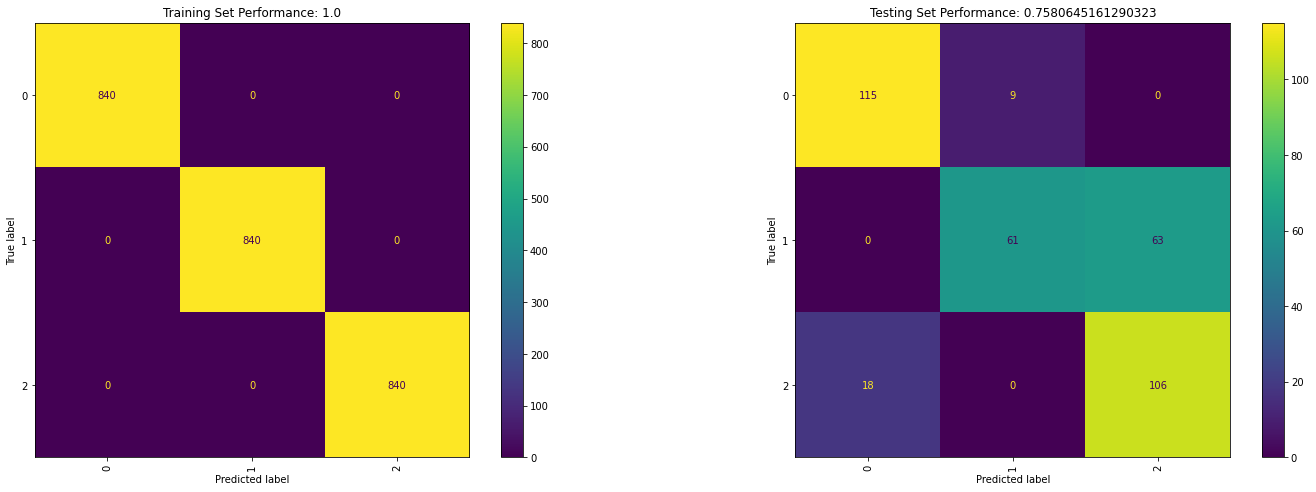

In [8]:
# Run the SVM, again timing it all.
svm_start = time.process_time()
hog_svm = SVC(kernel='rbf').fit(x_train_hog, y_train)
svm_end_train = time.process_time()
eval_model(hog_svm, x_train_hog, y_train, x_test_hog, y_test)
svm_end_eval = time.process_time()
print('The SVM with HOG took %d seconds to train and %d seconds to eval.' % \
      (svm_end_train - svm_start, svm_end_eval - svm_end_train))

We have to wait a while for HOG to transform all the features; but then the SVM is very fast. We're still overfitting, but performance on the test set is much better. Again, I could improve this with a grid search (which is now much more feasible than it was before). But given the growing length of this example I've decided this is outside of the scope of this example. Consider this an exercise for your own time.

Let's try some different HOG representations and see what happens. We'll consider a much coarser version, and a finer-grained version. 

(2520, 324)
(372, 324)
HOG took 42 seconds to do it's thing
The SVM with HOG took 0 seconds to train and 0 seconds to eval.


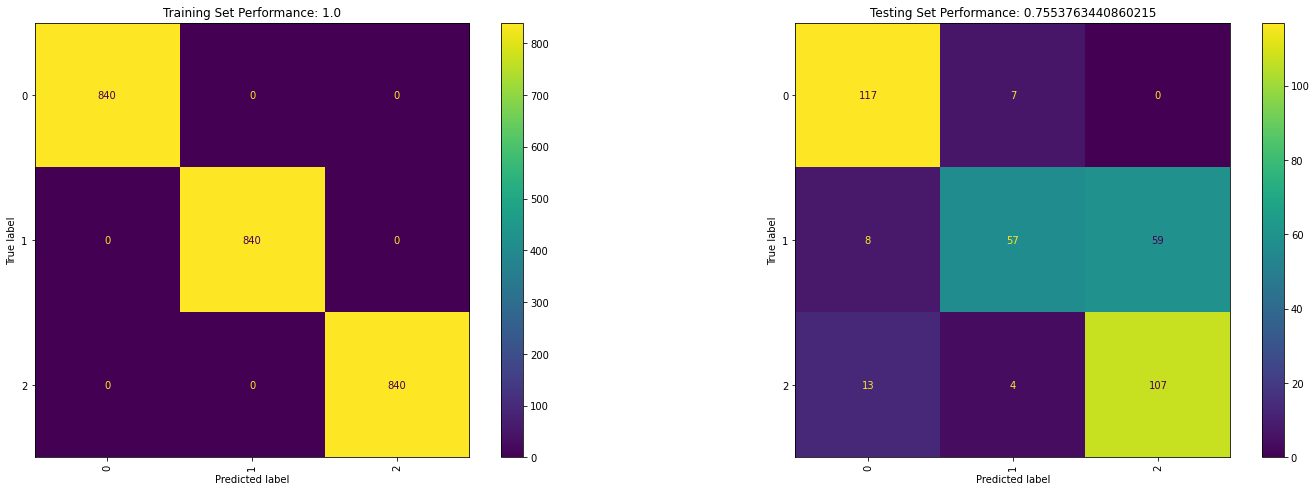

In [9]:
# coarse HOG
hog_start = time.process_time()
x_train_hog = transform_datset_to_hog(x_train, orientations=4, pixels_per_cell=(32, 32), cells_per_block=(1, 1))
x_test_hog = transform_datset_to_hog(x_test, orientations=4, pixels_per_cell=(32, 32), cells_per_block=(1, 1))
hog_end = time.process_time()
print(x_train_hog.shape)
print(x_test_hog.shape)
print('HOG took %d seconds to do it\'s thing' % (hog_end - hog_start))
svm_start = time.process_time()
hog_svm = SVC(kernel='rbf').fit(x_train_hog, y_train)
svm_end_train = time.process_time()
eval_model(hog_svm, x_train_hog, y_train, x_test_hog, y_test)
svm_end_eval = time.process_time()
print('The SVM with HOG took %d seconds to train and %d seconds to eval.' % \
      (svm_end_train - svm_start, svm_end_eval - svm_end_train))

(2520, 82944)
(372, 82944)
HOG took 130 seconds to do it's thing
The SVM with HOG took 1618 seconds to train and 14374 seconds to eval.


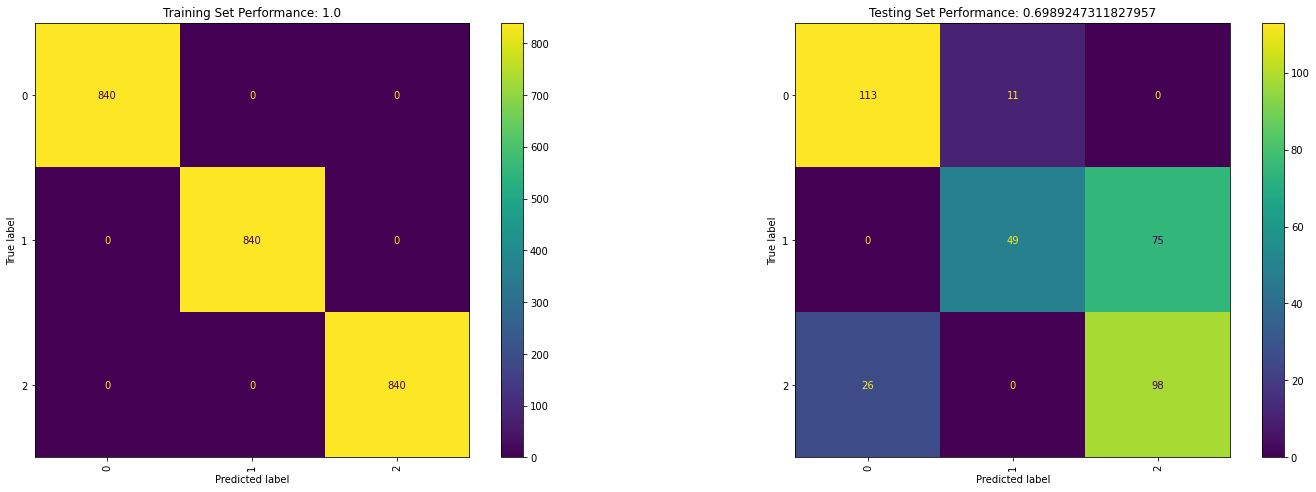

In [10]:
# fine-grained HOG
hog_start = time.process_time()
x_train_hog = transform_datset_to_hog(x_train, orientations=16, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
x_test_hog = transform_datset_to_hog(x_test, orientations=16, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
hog_end = time.process_time()
print(x_train_hog.shape)
print(x_test_hog.shape)
print('HOG took %d seconds to do it\'s thing' % (hog_end - hog_start))
svm_start = time.process_time()
hog_svm = SVC(kernel='rbf').fit(x_train_hog, y_train)
svm_end_train = time.process_time()
eval_model(hog_svm, x_train_hog, y_train, x_test_hog, y_test)
svm_end_eval = time.process_time()
print('The SVM with HOG took %d seconds to train and %d seconds to eval.' % \
      (svm_end_train - svm_start, svm_end_eval - svm_end_train))

I've so far ignored the dimensionality of my HOG feature, but we should look at that. In the coarse example, we end up with length $324$ features. We get this as follows:
* Our images are $300 \times 300$, with $32 \times 32$ cells this means we get $9 \times 9$ cells for each image.
* Each cell contains a 4 orientation histogram. So we get a $9 \times 9 \times 4 = 324$ vector for each image.

The fine-grained one is a bit bigger, at $82,944$ features. We have:
* $8 \times 8$ cells, so we get $37 \times 37$ cells for each image.
* We have a block size of $2 \times 2$. So we'll be grouping cells into little groups of four and stacking the histograms.
* Each cell has a $16$ bin histogram. So for each block we get $16 \times 2 \times 2$ features.
* With $37 \times 37$ cells and a block size of $2 \times 2$, we'll pull our $36 \times 36$ blocks. You can think of this as sliding the $2 \times 2$ over the  $37 \times 37$ cells and pulling out each possible block. If we start at the top left corner and slide across the top row, we'll pull out a block at each location until we get to the last cell in the row, at which point there's not enough cells to pull out a complete $2 \times 2$ block.
* All up, this means we have $36 \times 36 \times 64 = 82,944$ features per image.

In both cases our SVM performs similarly (overfitting), and in both cases we could address this (but that's out of scope). But this does raise another issue: when working with feature descriptors such as HOG, we need to consider the parameters of descriptor as well as the parameters of the classifier. To make matter annoying, these are also linked. Changing the parameters of our feature extractor will change our optimal classifier parameters.

### Other Feature Extraction Methods

There are a lot of other methods we could use for feature extraction. Within scikit-image, the [feature extractor module](https://scikit-image.org/docs/stable/api/skimage.feature.html) has quite a few options. Feature extraction methods such as [Local Binary Patterns](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html) will work in a similar way to HOG, i.e. extract a single feature descriptor for the whole image.

Other methods based around keypoints will first find keypoints (usually points where this is a rapid change in gradient, i.e. edges or corners) and then extract a descriptor around those keypoints. These individual descriptors are then combined to form an overall representation of the image. These method require a bit more effort to use with a classifier, as we can get a variable number of keypoints/descriptors per images. There are ways to resolve this however. 

The simple approach is to just extract features in a densly sampled manner. This is essentially what we do with HOG, we take every cell and extract a small descriptor, and stack them. However for HOG, the feature descriptor is small (usually just the $8$ orientations multiplied by the cell-size), where as other descriptors may be much bigger which is where the challenges come in.

The more complex approach is hinted at by the Bag of Words example. We can do something similar with the visual descriptors. Essentially, we can learn a set of "visual words", and then map the extracted descriptors into the "visual words" to obtain a fixed length feature. We'll revisit this idea in a later example.